In [ ]:
# encoding=utf8

# Linear Regression Analysis

To do a linear regression analysis on GVA data, which can be downloaded from "Regional Gross Value Added", 

https://www.ons.gov.uk/economy/grossvalueaddedgva/datasets/regionalgrossvalueaddedincomeapproach

# GVA in Bath and the surrounding area

**Original question:** Check how the current basic price for the GVA in Bath and the surrounding area has historically varied. Can a prediction be made for future values using a statistical regression?

The results show future values can be predicted, based on the available data. There seems to be a slight over-estimation in the results. This model could be improved by comparison with other areas, or by increasing the dataset size. I would advise checking this model against other approaches, using more flexible models, to see which model better represents the data. 

**Summary of results:**

-  2008/2009 shows evidence of decrease GVA. Probably due to economic crisis.
-  from 2009 to 2013 there's a plateau/minor increase.
-  There are steady increase in GVA from 1997 to 2008 and 2013 onwards.
-  Using the whole data to predict the GVA for 2016 and 2017 we get 18763.9473684 GBP for 2016 and 19322.9526316 GBP for 2017.
-  As the objective of this study is prediction, another model was developed in which the data was split into train/test. Predicted values for 2016 and 2017 are 19414.8142857 GBP and 20020.0321429 GBP, respectively.

In [2]:
import pandas as pd
from pandas.tools import plotting
#from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
from sklearn.metrics import mean_squared_error
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5

## Read file and select the tab

In [3]:
xls_file = pd.ExcelFile('../../DataSets/pybk017master/gvaireferencetables.xls')
Table1 = xls_file.parse('Table 1')

## Remove unwanted rows
Extra-Regio data and Statistical Discrepancy
If I was analysing all the tabs, I would use a more robust approach such as checking the lengh and then slicing by index.

In [4]:
T1 = Table1.iloc[:-3]

## Format dataframe
Transpose dataframe and set time column

In [5]:
T1.set_index('Region name', inplace = True)
T1.transpose()
T1 = T1.T
# UK_England= UK_England.rename(columns={'Region name': 'Year'})
T1 = T1.reset_index()
T1['Time'] = pd.to_datetime(T1['index'], format = '%Y')

# Make new column as the year 
T1['Time'] = pd.to_datetime(T1['Time'], format='%Y').dt.year

## Check if the data looks ok - Sanity checks
Extract Bath subset from dataframe and rename column

In [6]:
GVA = T1[['index', 'Time', 'Bath and North East Somerset, North Somerset and South Gloucestershire']]
GVA = GVA.rename(columns={'Bath and North East Somerset, North Somerset and South Gloucestershire' : 'GVA_at_current_price'})

In [7]:
GVA.describe()

Region name,Time,GVA_at_current_price
count,19.000000,19.000000
mean,2006.000000,13173.894737
std,5.627314,3173.707487
min,1997.000000,7985.000000
25%,2001.500000,10544.500000
50%,2006.000000,13519.000000
75%,2010.500000,15729.000000
max,2015.000000,17923.000000


Note on automation: I could look into some tests that would fail if GVA is negative, for example. Assuming this is a fair criteria.

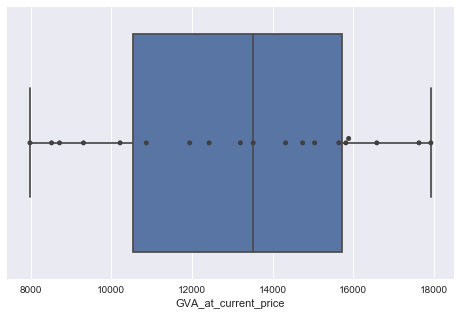

In [8]:
%matplotlib inline
fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
sns.boxplot(GVA.GVA_at_current_price)
sns.swarmplot(GVA.GVA_at_current_price, color=".25")

No outliers.

Left skewed data. Median closer to 3rd quartile.



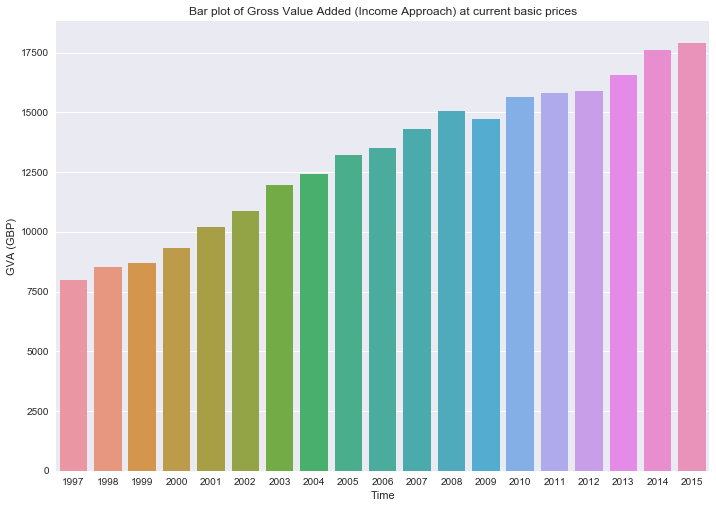

In [9]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
ax = sns.barplot(y='GVA_at_current_price', x = 'Time', data=GVA)
ax.set(xlabel='Time', ylabel='GVA (GBP)', title = 'Bar plot of Gross Value Added (Income Approach) at current basic prices')
sns.despine()

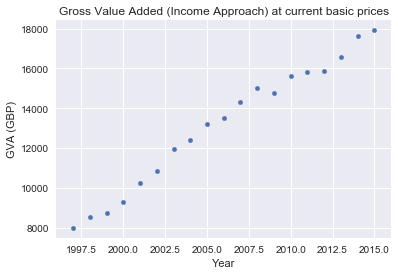

In [10]:
GVA.plot.scatter('Time', 'GVA_at_current_price')
plt.title('Gross Value Added (Income Approach) at current basic prices')
plt.xlim(1996, 2016)
plt.xlabel('Year'); plt.ylabel('GVA (GBP)')



Data is pretty linear. So linear regression seems to be a sensible approach.

## Linear regression

In [11]:
slope, intercept, r_value, p_value, std_err = stats.linregress(GVA['Time'], \
    GVA['GVA_at_current_price'])

In [12]:
print('The p-value between the 2 variables is measured as ' + str(p_value) + '\n')
print('Least squares linear model coefficients, intercept = ' + str(intercept) + \
  '. Slope = ' + str(slope)+'\n')
print('R-Squared = ' + str(r_value**2))
print('Standard error = ' + str(std_err))

The p-value between the 2 variables is measured as 2.31704866342e-16

Least squares linear model coefficients, intercept = -1108190.66316. Slope = 559.005263158

R-Squared = 0.982427140298
Standard error = 18.1327002039


The H0 (null-hypothesis) is rejected, which means that there is relationship between our X and Y.

R-squared is high. The model fits the data well.


In [13]:
# Create regression line
regressLine = intercept + GVA['Time']*slope

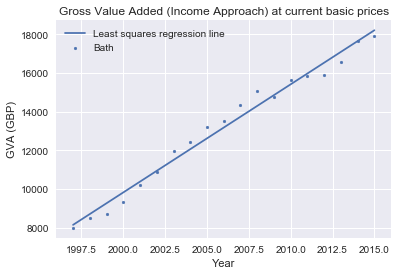

In [14]:
# Scatter plot 
plt.clf()
plt.scatter(GVA['Time'], GVA['GVA_at_current_price'], s = 8, label = 'Bath')
# least squares regression line
plt.plot(GVA['Time'], regressLine, label = 'Least squares regression line') 
plt.legend(loc = 'upper left')
plt.title('Gross Value Added (Income Approach) at current basic prices')
plt.xlim(1996, 2016)
plt.xlabel('Year'); plt.ylabel('GVA (GBP)')

### If I wanted to predict GVA for 2016 and 2017 using the above model:

In [15]:
regressLine = intercept + 2016*slope
print (str(regressLine) + ' GBP')

18763.9473684 GBP


In [16]:
regressLine = intercept + 2017*slope
print (str(regressLine) + ' GBP')

19322.9526316 GBP


### Train / test model

In practice I need to implement the linear regression on the training data and then I can test it.

If I was not dealing with time-series, I would randonly split the data into train/test. But time series occur in a temporal sequence that needs to be preserved. I will use the first 80% of the data to train the model and I will use the remaining 20% to test it.

In [17]:
training=GVA[GVA['Time']<=2011]
testing=GVA[GVA['Time']>2011]

In [18]:
training.shape, testing.shape

((15, 3), (4, 3))

In [19]:
np.unique(training['Time'])

array([1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007,
       2008, 2009, 2010, 2011])

The training period ranges from 1997 to 2011.

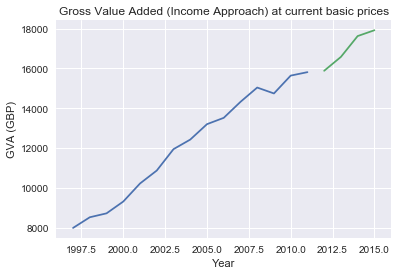

In [20]:
plt.plot(training['Time'], training['GVA_at_current_price'])
plt.plot(testing['Time'], testing['GVA_at_current_price'])
plt.title('Gross Value Added (Income Approach) at current basic prices')
plt.xlim(1996, 2016)
plt.xlabel('Year'); plt.ylabel('GVA (GBP)')
rcParams['figure.figsize'] = 10, 5

In [29]:
# Perform linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(training['Time'], \
    training['GVA_at_current_price'])

In [30]:
print('The p-value between the 2 variables is measured as ' + str(p_value) + '\n')
print('Least squares linear model coefficients, intercept = ' + str(intercept) + \
  '. Slope = ' + str(slope)+'\n')
print('R-Squared = ' + str(r_value**2))
print('Standard error = ' + str(std_err))

The p-value between the 2 variables is measured as 5.28297100348e-13

Least squares linear model coefficients, intercept = -1200704.38571. Slope = 605.217857143

R-Squared = 0.983677235835
Standard error = 21.622733704


Null-hypothesis is rejected.

R-squared shows that there's a good fit.

The standard error or the estimate shows the accuracy of predictions. It represents the average distance of the observed value to the regression line

In [31]:
# Create regression line
regressLine = intercept + training['Time']*slope

In [32]:
# Check values
predicted= intercept + testing['Time']*slope
index = testing['Time']
obs_pred=pd.DataFrame({"Observation":testing.GVA_at_current_price,"Predicted":predicted, "Years":index})
obs_pred

,Observation,Predicted,Years
15,15885,16993.942857,2012
16,16583,17599.160714,2013
17,17630,18204.378571,2014
18,17923,18809.596429,2015


In [33]:
predict2016 = intercept + 2016*slope
predict2017 = intercept + 2017*slope
print('Predicted values for 2016 and 2017 are ' + str(predict2016) + \
  ' and ' + str(predict2017)+'\n')

Predicted values for 2016 and 2017 are 19414.8142857 and 20020.0321429



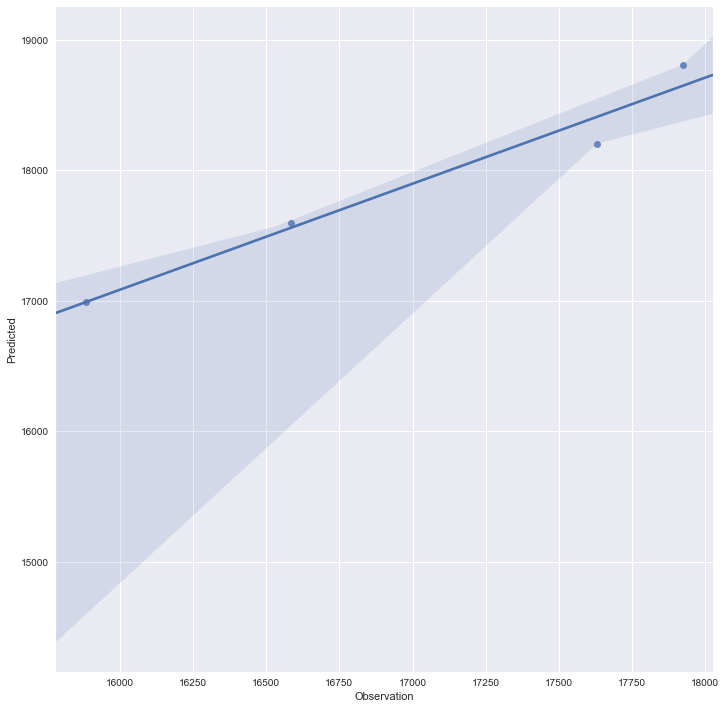

In [34]:
# obs_pred.plot(kind='scatter', x='Observation', y='Predicted',color='DarkBlue')
# plt.show()
sns.pairplot(obs_pred, x_vars=['Observation'], y_vars='Predicted', size=10, aspect=1, kind='reg')
plt.show()

The model overestimates the GVA.

In [35]:
# difference between predicted and observed
RMSE = (mean_squared_error(obs_pred['Observation'], obs_pred['Predicted']))**0.5
RMSE

919.00772958360483